In [1]:
from dataset import FSDDLoader, DataMode

import joblib
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
RANDOM_STATE = 42

In [3]:
loader = FSDDLoader(max_duration=0.9)

In [4]:
aggregate_data = loader.load(mode=DataMode.AGGREGATE)
flatten_data = loader.load(mode=DataMode.FLATTEN)
sequence_data = loader.load(mode=DataMode.SEQUENCE)

joblib.dump(aggregate_data, "dataset/aggregate_data.pkl")
joblib.dump(flatten_data, "dataset/flatten_data.pkl")
joblib.dump(sequence_data, "dataset/sequence_data.pkl")

['dataset/sequence_data.pkl']

In [5]:
print("Aggregate data shape:", aggregate_data[0].shape)
print("Flatten data shape:", flatten_data[0].shape)
print(f"Sequence data length: {len(sequence_data[0])} × {sequence_data[0][0].shape}")

Aggregate data shape: (3000, 26)
Flatten data shape: (3000, 1183)
Sequence data length: 3000 × (91, 13)


In [6]:
X_agg, y_agg, speakers_agg = aggregate_data
X_flat, y_flat, speakers_flat = flatten_data
X_seq, y_seq, speakers_seq = sequence_data

In [7]:
def split_by_speakers(X, y, speakers, n_test_speakers, random_state=42):
    unique_speakers = np.unique(speakers)
    np.random.seed(random_state)
    test_speakers = np.random.choice(unique_speakers, size=n_test_speakers, replace=False)
    print(f"Selected test speakers: {test_speakers}")

    train_mask = np.isin(speakers, test_speakers, invert=True)
    test_mask = ~train_mask

    return (X[train_mask], X[test_mask],
            y[train_mask], y[test_mask],
            speakers[train_mask], speakers[test_mask])

## Classical Models On Aggregate Data With Familiar Speakers vs New Speakers

In [8]:
from models.model import BaseClassificationModel
from models.classical_models import KNNModel, SVMModel, RandomForestModel

In [9]:
classical_models : dict[str, BaseClassificationModel] = {
    "KNN": KNNModel(k=5),
    "SVM": SVMModel(kernel='linear', C=1.0, gamma='scale', random_state=RANDOM_STATE),
    "RandomForest": RandomForestModel(n_estimators=100, max_depth=None, random_state=RANDOM_STATE)
}

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_agg, y_agg, test_size=0.2, random_state=42, stratify=y_agg)

KNN:


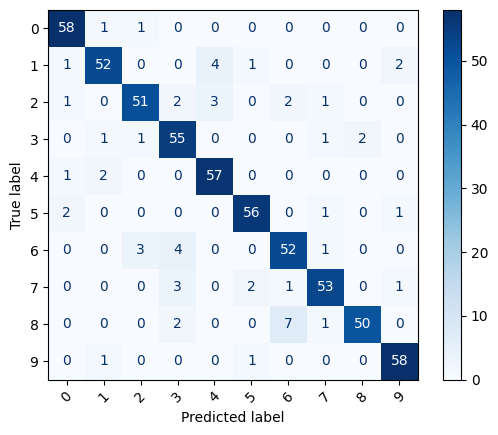

accuracy: 0.9033
precision: 0.9050
recall: 0.9033
f1: 0.9031
SVM:


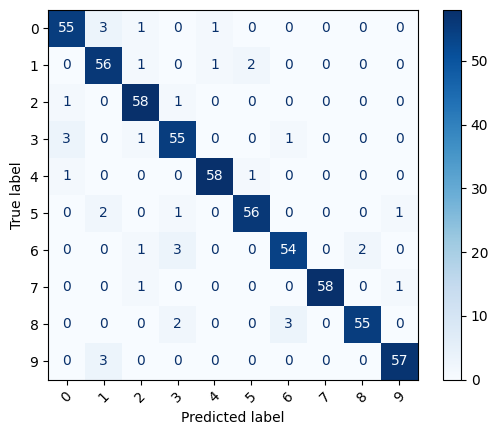

accuracy: 0.9367
precision: 0.9377
recall: 0.9367
f1: 0.9369
RandomForest:


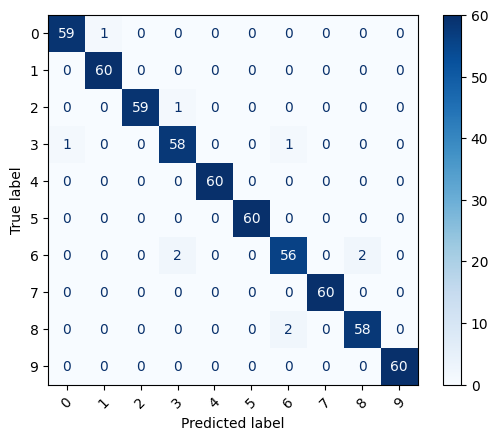

accuracy: 0.9833
precision: 0.9834
recall: 0.9833
f1: 0.9833


In [11]:
for name, model in classical_models.items():
    print(f"{name}:")
    model.train_and_evaluate(X_train, y_train, X_test, y_test, show_confusion=True)

In [19]:
X_train, X_test, y_train, y_test, _, _ = split_by_speakers(X_agg, y_agg, speakers_agg, n_test_speakers=2, random_state=RANDOM_STATE)

Selected test speakers: ['george' 'jackson']


KNN:
Train results:


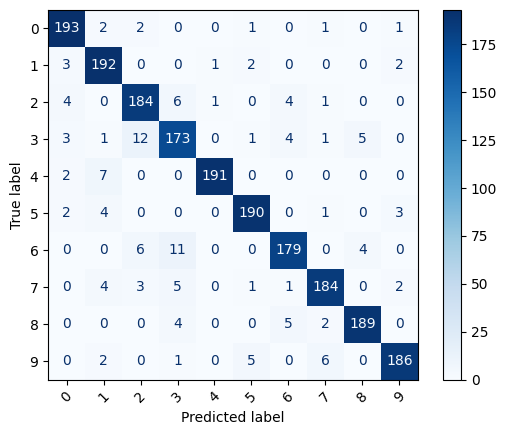

Test results:


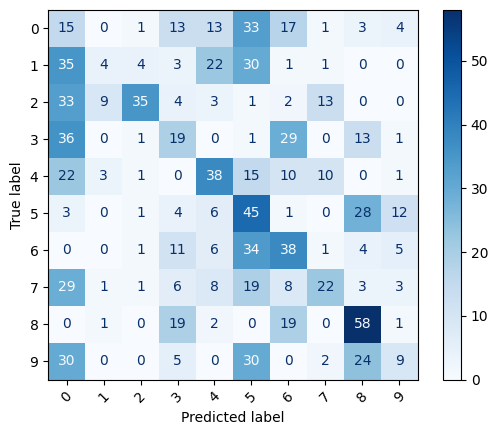


Metric          Train       Test
--------------------------------
accuracy       0.9305     0.2830
precision      0.9311     0.3334
recall         0.9305     0.2830
f1             0.9306     0.2793

SVM:
Train results:


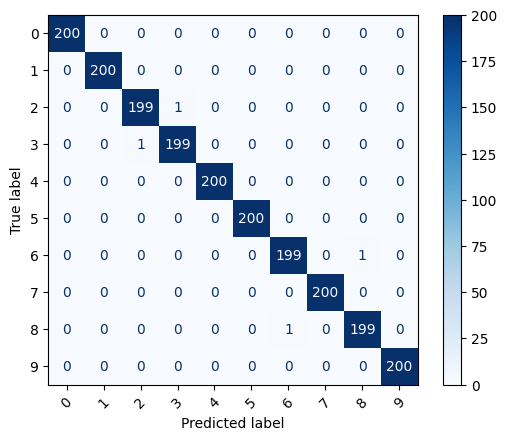

Test results:


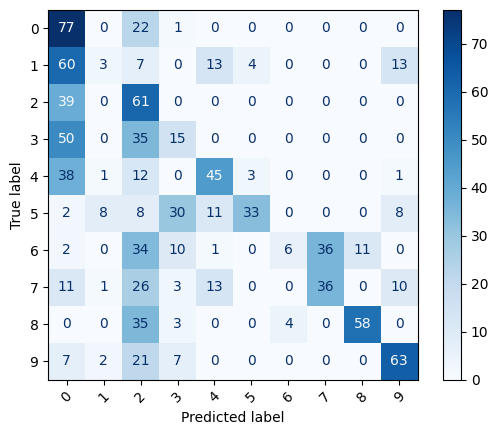


Metric          Train       Test
--------------------------------
accuracy       0.9980     0.3970
precision      0.9980     0.4891
recall         0.9980     0.3970
f1             0.9980     0.3790

RandomForest:
Train results:


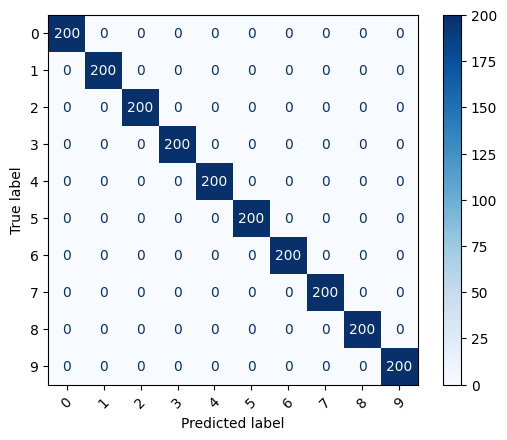

Test results:


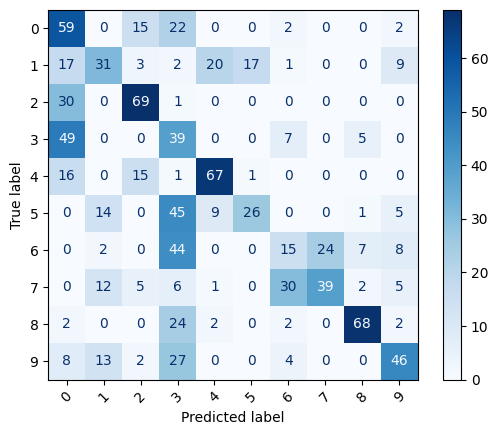


Metric          Train       Test
--------------------------------
accuracy       1.0000     0.4590
precision      1.0000     0.5124
recall         1.0000     0.4590
f1             1.0000     0.4654



In [26]:
for name, model in classical_models.items():
    print(f"{name}:")
    model.train(X_train, y_train)

    print("Train results:")
    train_results = model.evaluate(X_train, y_train, show_confusion=True)
    print("Test results:")
    test_results = model.evaluate(X_test, y_test, show_confusion=True)

    print("\n{:<10} {:>10} {:>10}".format("Metric", "Train", "Test"))
    print("-" * 32)
    for (metric, train_val), (_, test_val) in zip(train_results.items(), test_results.items()):
        print("{:<10} {:>10.4f} {:>10.4f}".format(metric, train_val, test_val))
    print()

We observe that the models perform significantly better on familiar speakers compared to new speakers, which indicates overfitting to the training data.

## Classical Models On Flattened Data